In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd My Drive/RES

/content/drive/My Drive/RES


In [ ]:
from pandas import read_csv
import pandas as pd
from datetime import datetime
import missingno as msno

from math import sqrt
import numpy as np
from numpy.random import randn  
np.seterr(divide='ignore', invalid='ignore');
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
import random
import time

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GRU, LeakyReLU, BatchNormalization, LSTM, Conv2D, Conv2DTranspose, Flatten, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, callbacks, Model
from tensorflow.keras.models import load_model

!pip install pyts
from pyts.image import GramianAngularField as GAF
from mpl_toolkits.axes_grid1 import ImageGrid

series = pd.read_csv("Turbine_Data.csv")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.4 MB/s eta 0:00:00


<Axes: >

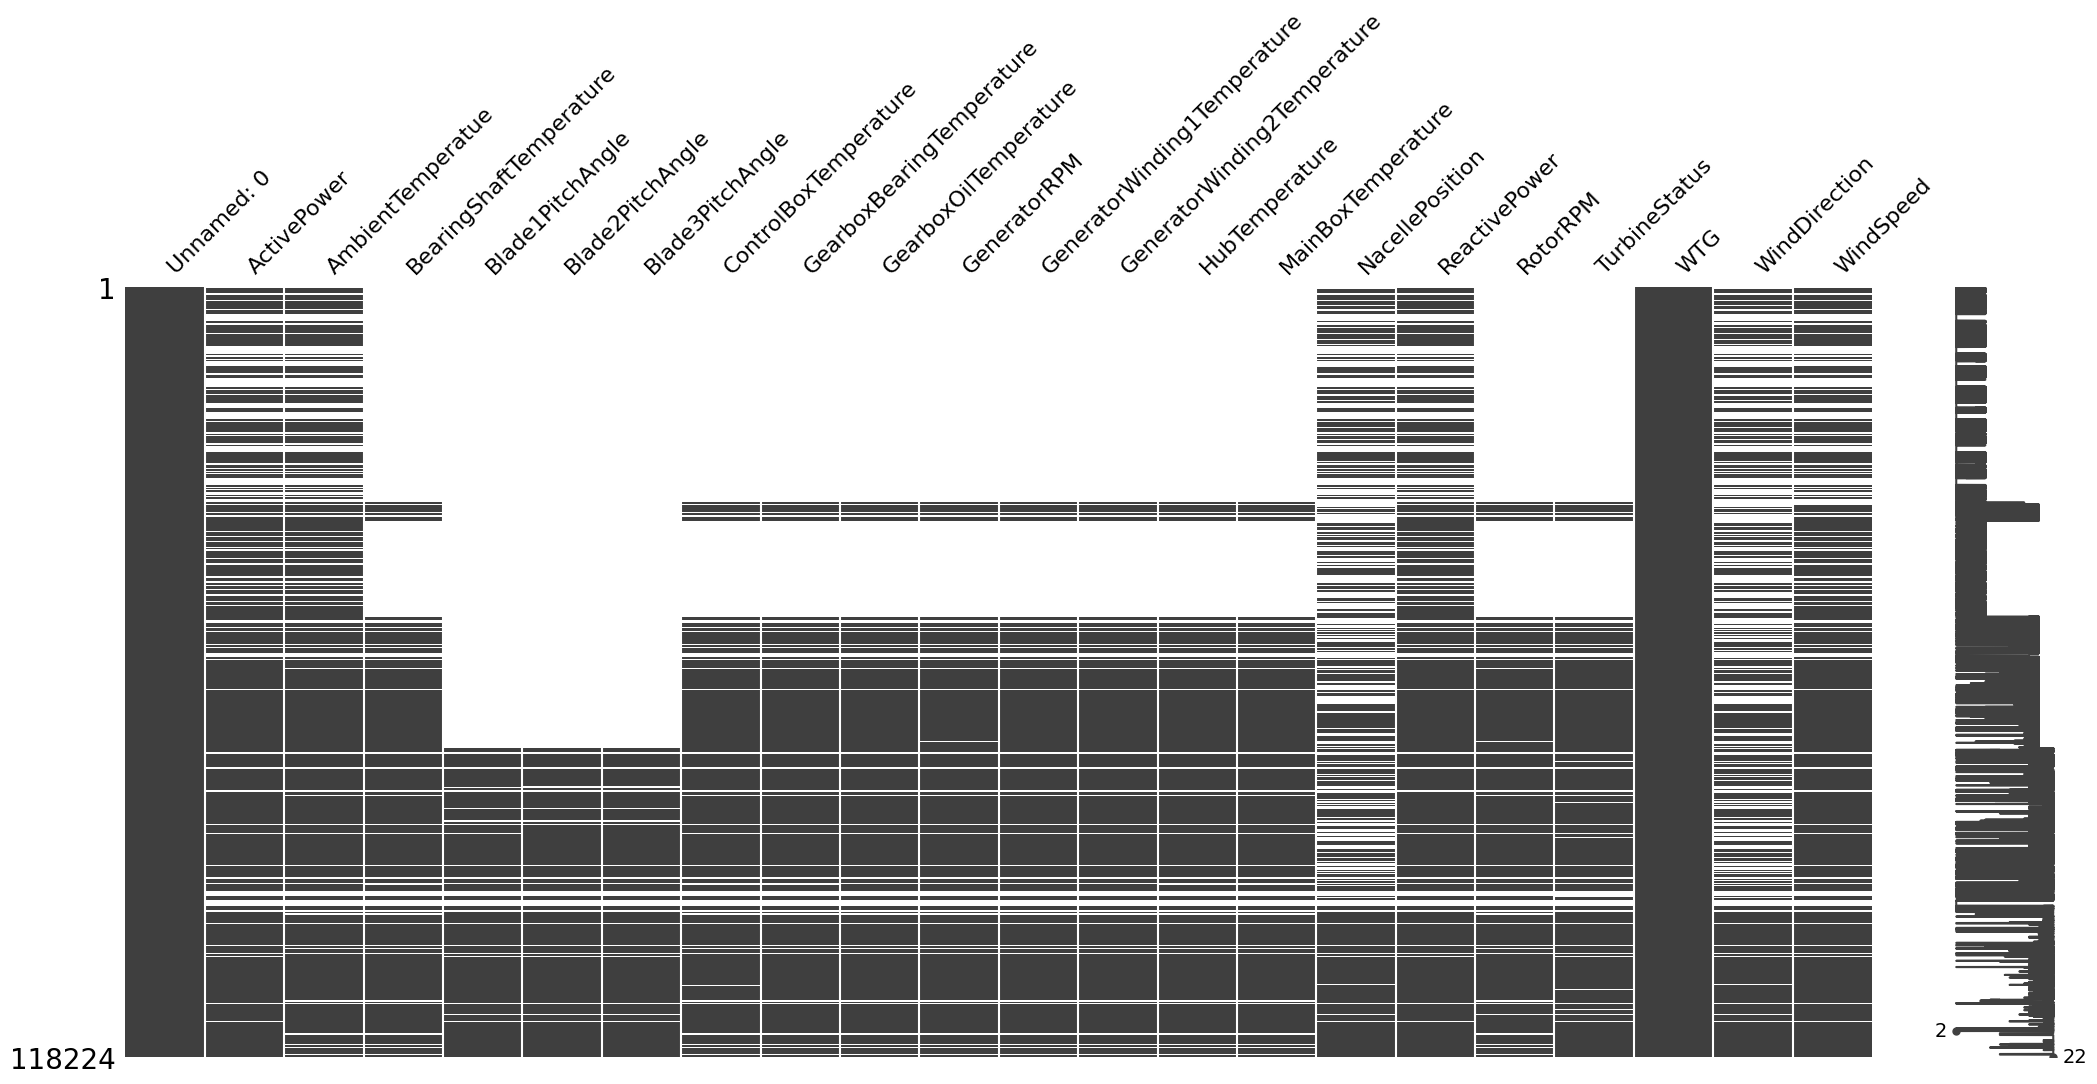

In [ ]:
msno.matrix(series)

<ipython-input-8-c27a2e427c35>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(series.corr(), annot=True, square=True)


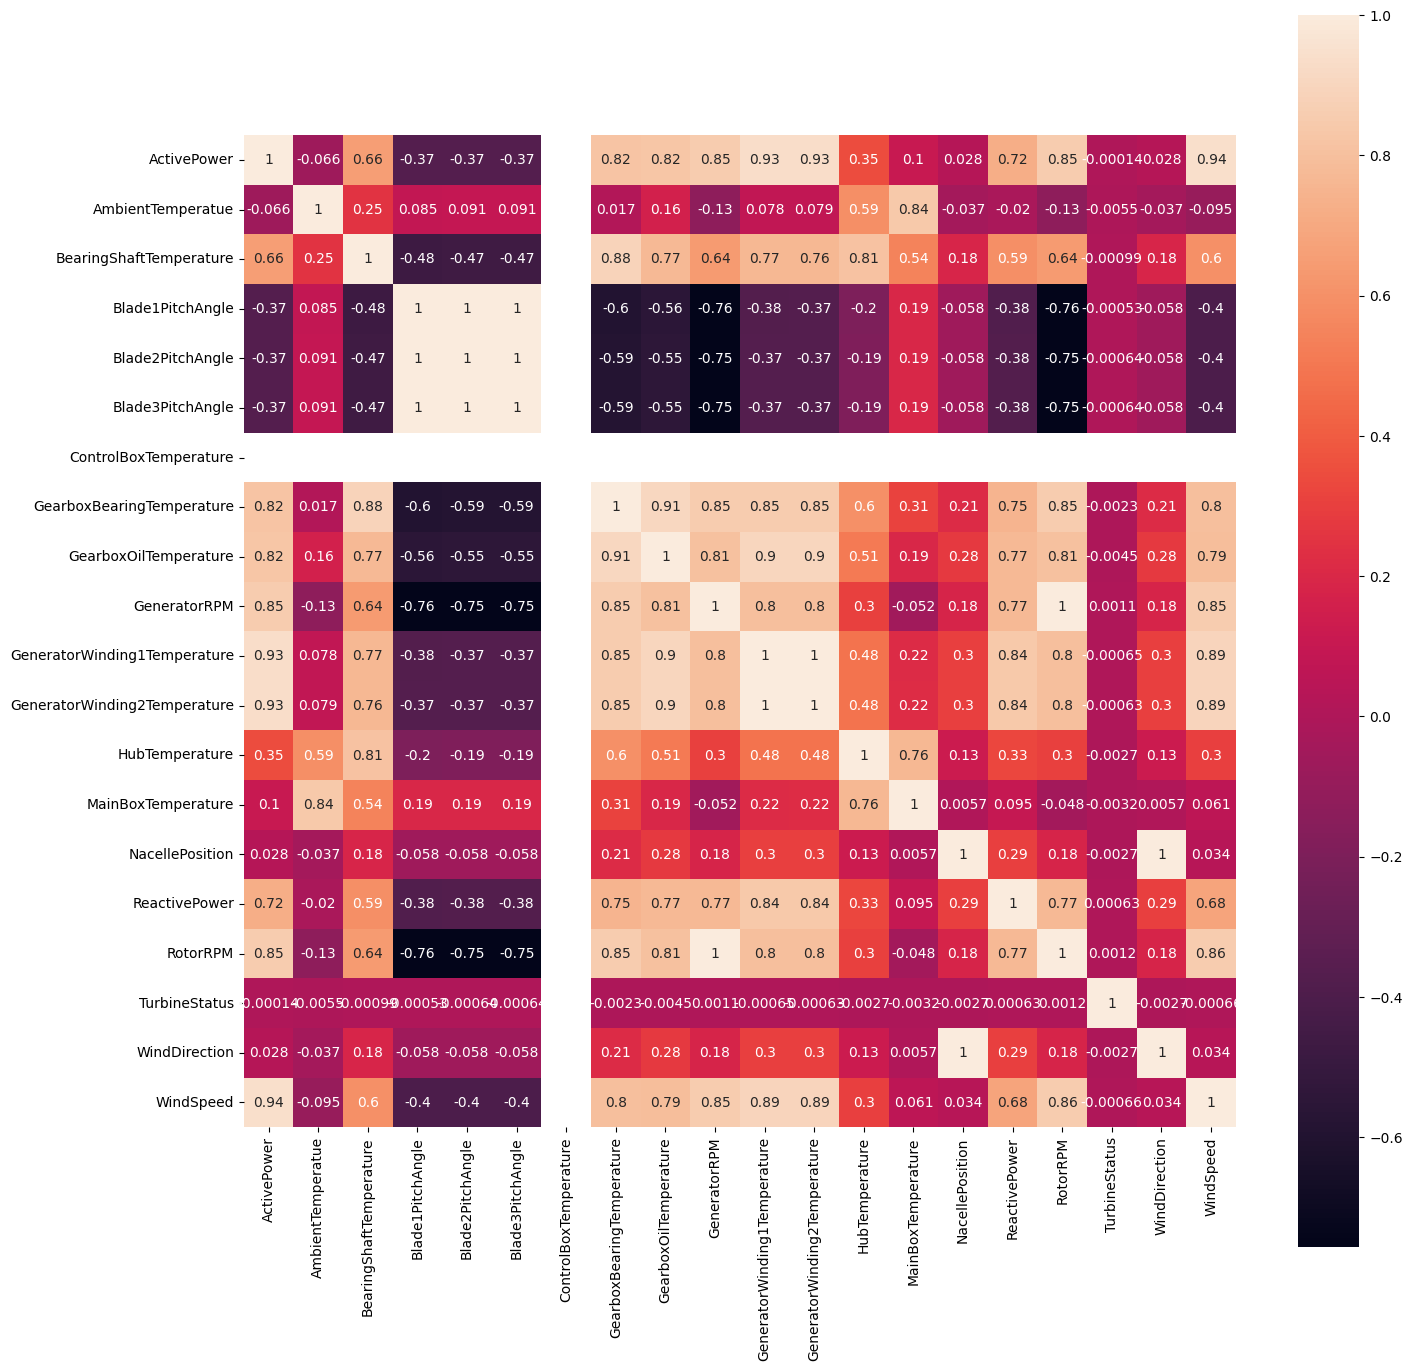

In [ ]:
plt.subplots(figsize=(16, 16))
sns.heatmap(series.corr(), annot=True, square=True)
plt.show()

In [ ]:
idxs = []
for i, corr in enumerate(series.corr()['ActivePower']):
    if corr > 0 and pd.notna(corr):
        idxs.append(i)
        
idxs = idxs[1:]
selected_features = series.corr()['ActivePower'][idxs]
selected_features = selected_features.drop(labels=['GearboxOilTemperature', 'GeneratorWinding1Temperature', 'RotorRPM', 'NacellePosition'])
sel_feature_names = [idx for idx, val in selected_features.iteritems()]
sel_feature_names.insert(0, 'ActivePower')
reduced_df = series[sel_feature_names]
print(f"The selected features are:\n{sel_feature_names}")

<ipython-input-9-2d5362cb3374>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for i, corr in enumerate(series.corr()['ActivePower']):
<ipython-input-9-2d5362cb3374>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  selected_features = series.corr()['ActivePower'][idxs]


The selected features are:
['ActivePower', 'BearingShaftTemperature', 'GearboxBearingTemperature', 'GeneratorRPM', 'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature', 'ReactivePower', 'WindDirection', 'WindSpeed']


<ipython-input-9-2d5362cb3374>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  sel_feature_names = [idx for idx, val in selected_features.iteritems()]


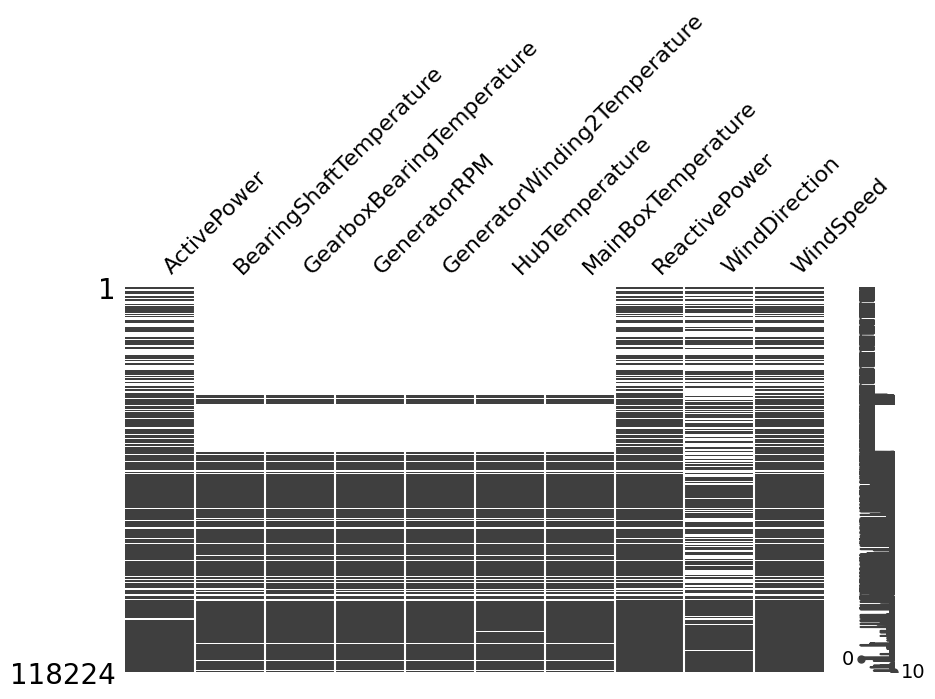

In [ ]:
msno.matrix(reduced_df, figsize=(10,5))
plt.show()

In [ ]:
rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)
reduced_df = reduced_df.fillna(0).astype(float)
reduced_df = pd.concat((time_df, reduced_df), axis=1)
reduced_df = reduced_df.set_index(0)
reduced_df = reduced_df.loc['2019-12-17':]

In [ ]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    me = np.mean(forecast - actual)             # ME
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    
    mpe = np.mean((forecast - actual)/actual)   # MPE
    
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

def invert_values(y_pred, y_test, scaler) -> tuple:
    n_ahead = 144
    rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
    time_df = pd.DataFrame(rng)
    days = time_df.values[-len(y_pred):-len(y_pred) + n_ahead]
    days_df = pd.DataFrame(days)

    pred_n_ahead = pd.DataFrame(y_pred)
    actual_n_ahead = pd.DataFrame(y_test)
    pr_p = pd.concat([pred_n_ahead]*len(sel_feature_names), axis=1)
    ac_p = pd.concat([actual_n_ahead]*len(sel_feature_names), axis=1)
    pred_power = scaler.inverse_transform(pr_p)[:,0]
    actual_power = scaler.inverse_transform(ac_p)[:,0]
    
    return pred_power, actual_power



def plot_random_predictions(pred_power, actual_power, n_predictions=6):
    if n_predictions > 21:
        print('Error: there are only 21 days in the predicted set')
        return
    days = np.arange(0,21)
    np.random.shuffle(days)
    cond_color = np.where(actual_power==0, 'lime', plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

    fig, ax = plt.subplots(3,2, figsize=(30, 20))

    ax_h = 0
    ax_v = 0
    for i in range(0,n_predictions):
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], label="actual")
        ax[ax_h,ax_v].scatter(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], color=cond_color[days[i]*144:(days[i]+1)*144])
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], pred_power[days[i]*144:(days[i]+1)*144], marker='o', label="prediction")
        ax[ax_h,ax_v].legend()
        ax[ax_h,ax_v].set_title(f"Predicted vs. Actual Power (Day {days[i]+1})")
        ax[ax_h,ax_v].set_xlabel("Time")
        ax[ax_h,ax_v].set_ylabel("Power (kW)")
        if i%2 == 0:
            ax_v = 1
        else:
            ax_h += 1
            ax_v = 0

    plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(reduced_df.values)
data_scaled = scaler.transform(reduced_df.values)

In [ ]:
test_split_days = 21 # 20%
val_split_days = 10 # around 10%

test_split_idx = len(reduced_df)-144*test_split_days
val_split_idx = test_split_idx-144*val_split_days

print("-- Regression --")
train_data = data_scaled[:test_split_idx]
test_data = data_scaled[test_split_idx:]
print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}\n")

print("-- NN --")
train_data_nn = data_scaled[:val_split_idx]
val_data_nn = data_scaled[val_split_idx:test_split_idx]
test_data_nn = data_scaled[test_split_idx:]
print(f"Train data shape: {train_data_nn.shape}\nVal data shape: {val_data_nn.shape}\nTest data shape: {test_data_nn.shape}")

-- Regression --
Train data shape: (12096, 10)
Test data shape: (3024, 10)

-- NN --
Train data shape: (10656, 10)
Val data shape: (1440, 10)
Test data shape: (3024, 10)


In [ ]:
print("-- Regression --")
x_train, y_train = train_data[:,1:], train_data[:,0]
print(f"Train values shape: {x_train.shape}\nTrain labels shape: {y_train.shape}")

x_test, y_test = test_data[:,1:], test_data[:,0]
print(f"Test values shape: {x_train.shape}\nTest labels shape: {y_train.shape}\n")

print("-- NN --")
x_train_nn, y_train_nn = train_data_nn[:,1:], train_data_nn[:,0]
print(f"Train values shape: {x_train_nn.shape}\nTrain labels shape: {y_train_nn.shape}")

x_val_nn, y_val_nn = val_data_nn[:,1:], val_data_nn[:,0]
print(f"Val values shape: {x_val_nn.shape}\nVal labels shape: {y_val_nn.shape}")

x_test_nn, y_test_nn = test_data_nn[:,1:], test_data_nn[:,0]
print(f"Test values shape: {x_test_nn.shape}\nTest labels shape: {y_test_nn.shape}\n")

-- Regression --
Train values shape: (12096, 9)
Train labels shape: (12096,)
Test values shape: (12096, 9)
Test labels shape: (12096,)

-- NN --
Train values shape: (10656, 9)
Train labels shape: (10656,)
Val values shape: (1440, 9)
Val labels shape: (1440,)
Test values shape: (3024, 9)
Test labels shape: (3024,)



##CNN

In [ ]:
features_data = reduced_df.values[:,1:]
gadf_scaler = GAF(method='s', sample_range=(0,1))
gadf_scaler.fit(features_data)
x_train_cnn = gadf_scaler.transform(features_data[:val_split_idx])
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0], x_train_cnn.shape[1], x_train_cnn.shape[2], 1)

x_val_cnn = gadf_scaler.transform(features_data[val_split_idx:test_split_idx])
x_val_cnn = x_val_cnn.reshape(x_val_cnn.shape[0], x_val_cnn.shape[1], x_val_cnn.shape[2], 1)

x_test_cnn = gadf_scaler.transform(features_data[test_split_idx:])
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0], x_test_cnn.shape[1], x_test_cnn.shape[2], 1)

In [ ]:
depth = 3
kernel_size = (3,3)
lrelu_alpha = 0.2
dropout = 0.4
n_filters = 32

inputs = Input(shape=x_train_cnn.shape[1:])
b = inputs
for i in range(1, depth+1):

    a = Conv2D(filters=n_filters*i, kernel_size=kernel_size, activation=None)(b)
    x = LeakyReLU(alpha=lrelu_alpha)(a)
    x = BatchNormalization()(x)
    b = Dropout(dropout)(x)
    
a = Conv2D(filters=n_filters*(i+1), kernel_size=kernel_size, activation=None)(x)
x = LeakyReLU(alpha=lrelu_alpha)(a)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(dropout)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model_cnn = Model(inputs, outputs)

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 32)          0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 32)         128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 64)          18496     
                                                             

In [ ]:
lr = 1e-4
patience = 10
min_delta_patience = 1e-4
loss = 'mae'
metrics = 'mae'
checkpoint_path = 'best_cnn.hdf5'

weights_save = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta_patience)
model_cnn.compile(optimizer = Adam(learning_rate=lr), loss=loss, metrics=metrics)

Epoch 1/100
333/333 [==============================] - 14s 25ms/step - loss: 0.3376 - mae: 0.3376 - val_loss: 0.2214 - val_mae: 0.2214
Epoch 2/100
333/333 [==============================] - 7s 20ms/step - loss: 0.3065 - mae: 0.3065 - val_loss: 0.1724 - val_mae: 0.1724
Epoch 3/100
333/333 [==============================] - 5s 15ms/step - loss: 0.2852 - mae: 0.2852 - val_loss: 0.1715 - val_mae: 0.1715
Epoch 4/100
333/333 [==============================] - 8s 25ms/step - loss: 0.2715 - mae: 0.2715 - val_loss: 0.1779 - val_mae: 0.1779
Epoch 5/100
333/333 [==============================] - 6s 18ms/step - loss: 0.2640 - mae: 0.2640 - val_loss: 0.1827 - val_mae: 0.1827
Epoch 6/100
333/333 [==============================] - 8s 24ms/step - loss: 0.2571 - mae: 0.2571 - val_loss: 0.1849 - val_mae: 0.1849
Epoch 7/100
333/333 [==============================] - 5s 15ms/step - loss: 0.2486 - mae: 0.2486 - val_loss: 0.1747 - val_mae: 0.1747
Epoch 8/100
333/333 [==============================] - 9s 27m

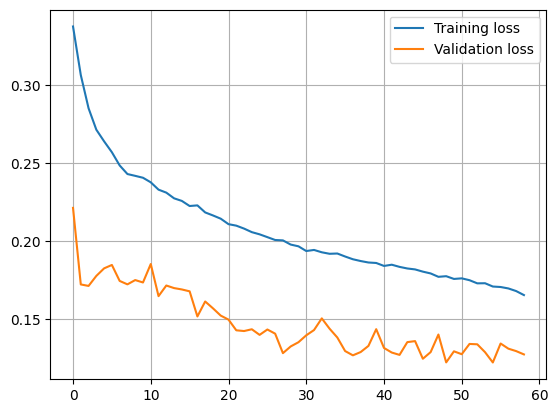

In [ ]:
epochs = 100
batch_size = 32

history_cnn = model_cnn.fit(x_train_cnn,
                            y_train_nn,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(x_val_cnn, y_val_nn),
                            shuffle=False,
                            callbacks=[early_stopping, weights_save])

plt.plot(history_cnn.history['loss'], label='Training loss')
plt.plot(history_cnn.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.grid()
plt.show()

model_cnn.load_weights(checkpoint_path)

In [ ]:
y_pred_cnn = model_cnn.predict(x_test_cnn)
pred_power_cnn, actual_power_cnn = invert_values(y_pred_cnn.reshape(-1, ), y_test_nn, scaler)

forecast_accuracy(pred_power_cnn, actual_power_cnn)

95/95 [==============================] - 1s 6ms/step


{'mape': inf,
 'me': -224.21714134842534,
 'mae': 258.64405328427654,
 'mpe': inf,
 'rmse': 472.7260775501712,
 'corr': 0.6612124306008311,
 'minmax': 0.03618558412245676}

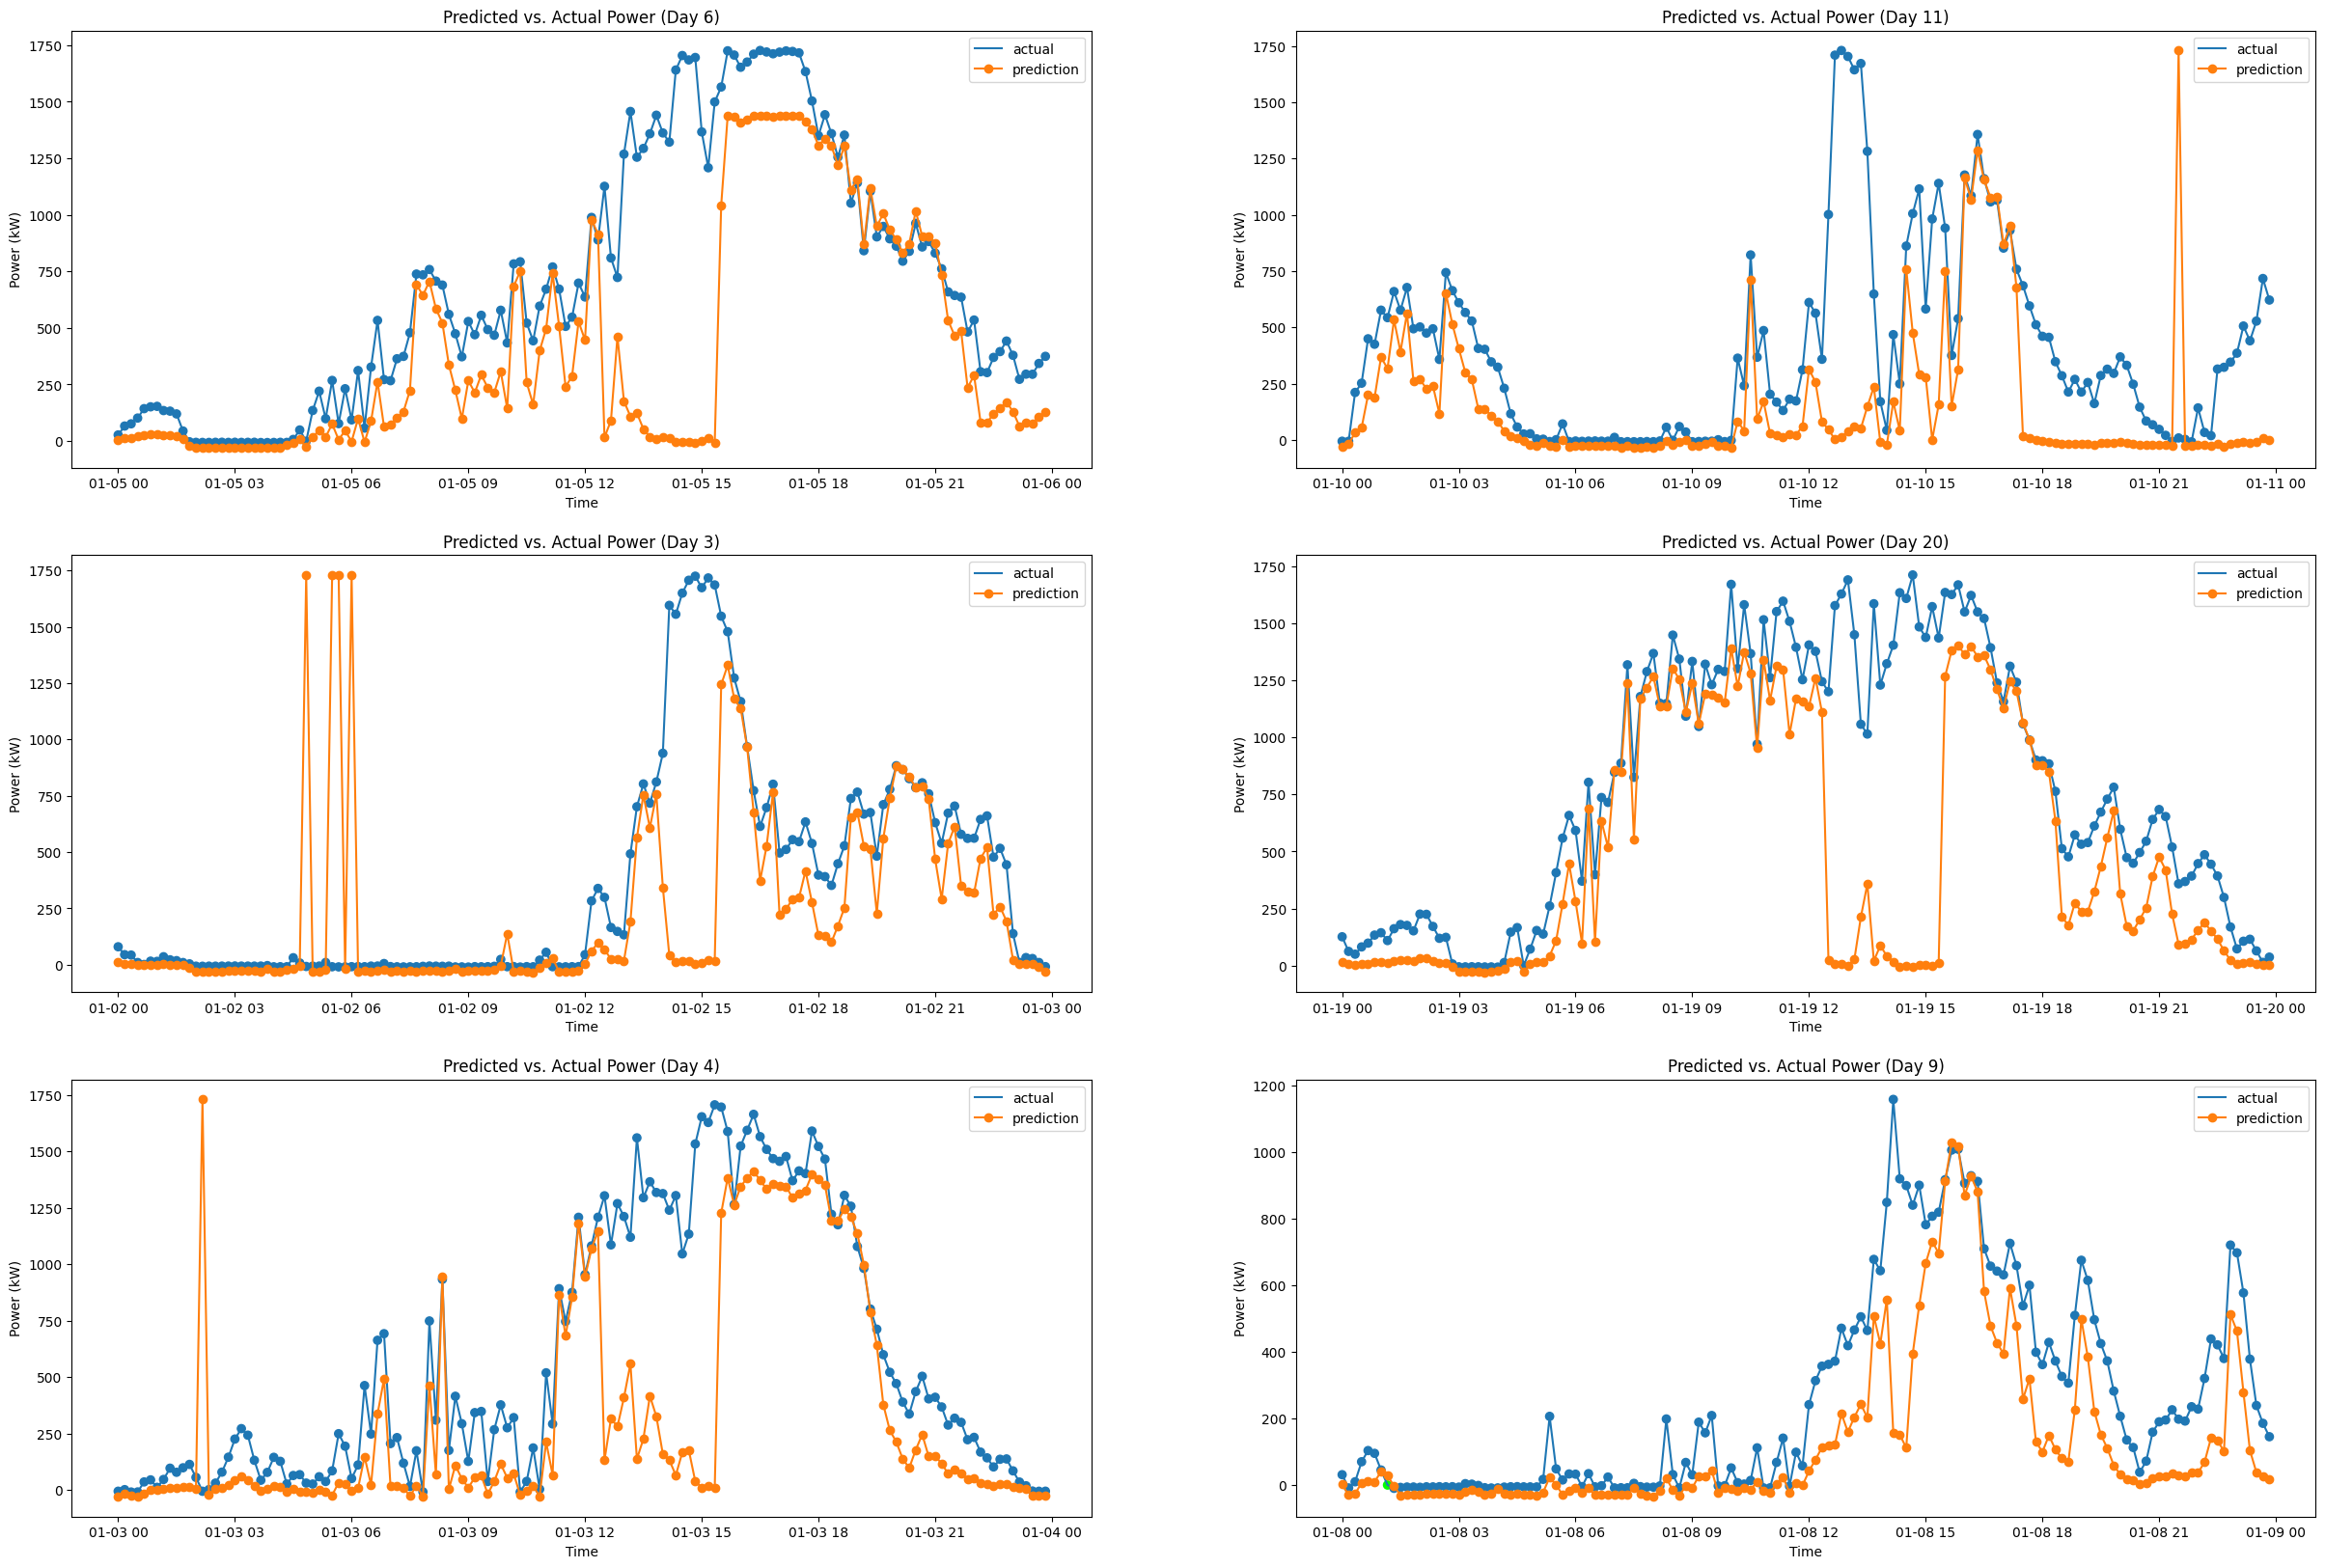

In [ ]:
plot_random_predictions(pred_power_cnn, actual_power_cnn)

In [ ]:
residuals_cnn = pd.Series(pred_power_cnn-actual_power_cnn)
residuals_cnn.describe()

count    3024.000000
mean     -224.217141
std       416.237806
min     -1756.322185
25%      -252.081527
50%      -134.248416
75%       -23.710062
max      1739.248733
dtype: float64

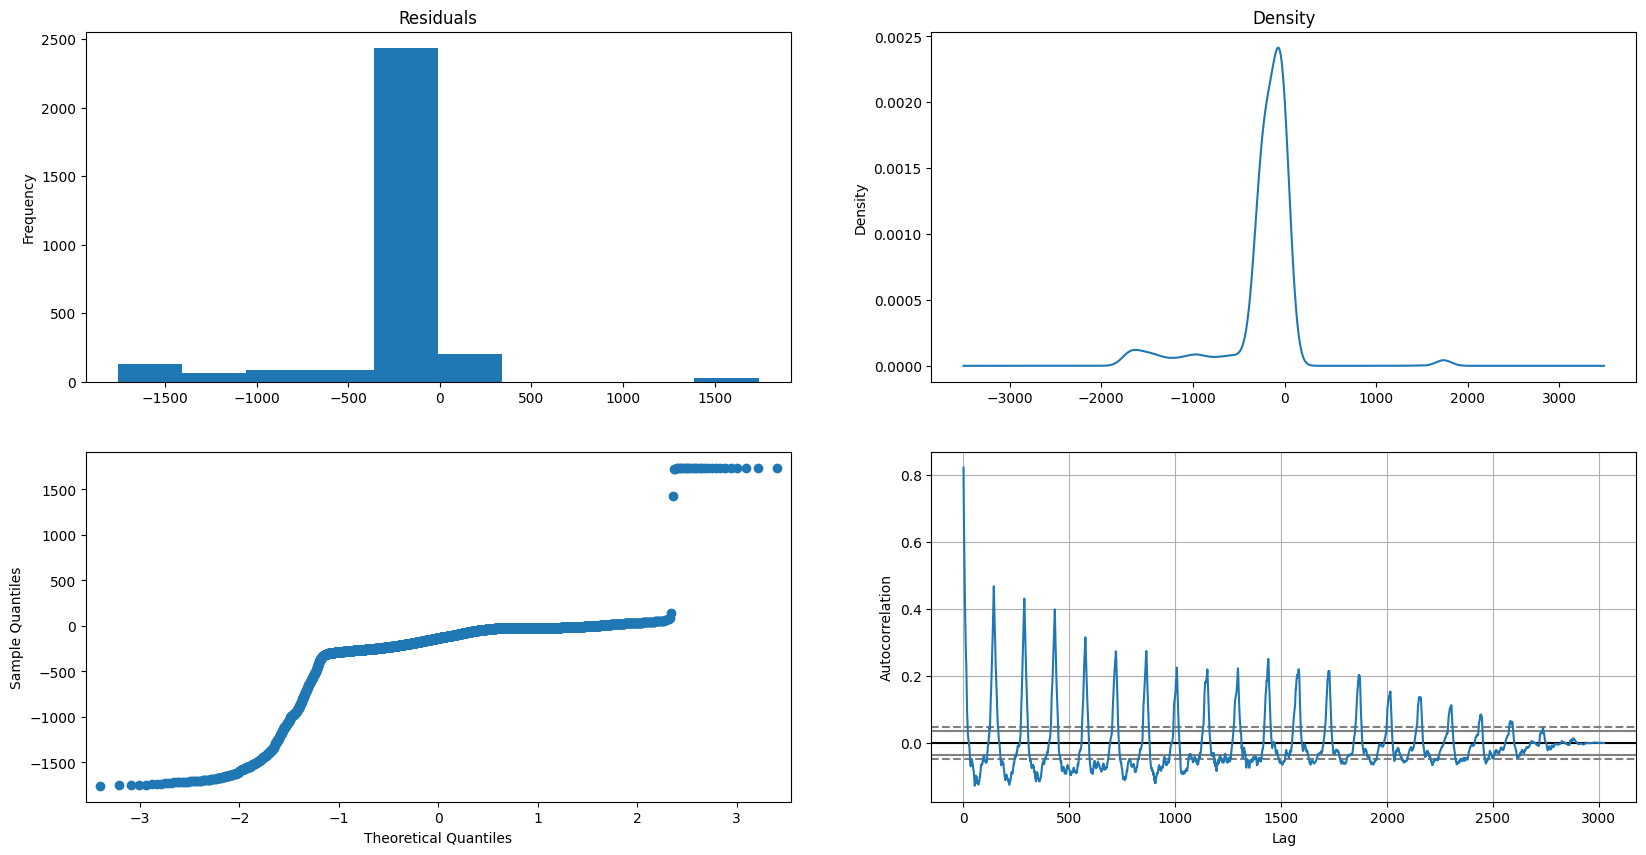

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
residuals_cnn.plot(kind='hist', title="Residuals", ax=ax[0,0])
residuals_cnn.plot(kind='kde', title='Density', ax=ax[0,1])
qqplot(residuals_cnn, ax=ax[1,0])
autocorrelation_plot(residuals_cnn, ax=ax[1,1])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model_cnn.layers]
feature_map_model = Model(inputs=model_cnn.inputs, outputs=layer_outputs)
feature_maps = feature_map_model.predict(x_test_cnn)

95/95 [==============================] - 1s 9ms/step


In [ ]:
for i, layer in enumerate(model_cnn.layers):
    if 'conv' in layer.name:
        print(i)

1
5
9
12


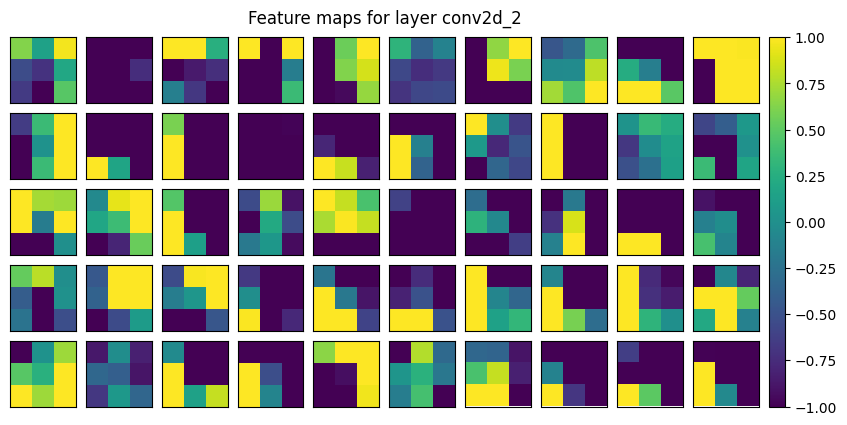

In [ ]:
show_layer = 9

fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(feature_maps[show_layer][0, :, :, i], origin='lower', vmin=-1., vmax=1.)
    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle(f"Feature maps for layer {model_cnn.layers[show_layer].name}", y=0.92)
plt.show()